In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../..')
sys.path.append('..')
from collections_env.gymcollectionsenv import CollectionsEnv 
from dcc import Parameters, AAV
from collections_env.discwrapper import DiscretizedObservationWrapper, DiscretizedActionWrapper
from learning.utils.pricer import MCPricer
p = Parameters()    
env = CollectionsEnv()
denv = DiscretizedObservationWrapper(env, [10, 100])
aav= AAV(p)
pricer = MCPricer(p, env.MIN_ACCOUNT_BALANCE)

[INFO] [2020-05-14 12:13:47,920] [AAV] - Instantiated @ AAV


In [5]:
def value_aav(env):
    n = 1000
    a = 0
    reward_per_episode = []
    for i in range(n):
        env.reset()
        tot_reward_per_episode = 0
        terminal = False
        while not terminal:
            state_next, reward, terminal, _ = env.step(a)
            # print(f'Start state: {env.starting_state}')
            tot_reward_per_episode += reward
            if terminal:
                reward_per_episode.append(tot_reward_per_episode)
    estimated = np.mean(reward_per_episode)
    aav = AAV(p)
    exact_v = -aav.u(env.lambda0, env.w0)
    v_cutoff = pricer.price(env.lambda0, env.w0)
    plt.show()
    plt.plot(reward_per_episode, marker='x')
    plt.axhline(exact_v, color='red', linestyle='--')
    plt.axhline(v_cutoff, color='orange', linestyle='--')
    plt.axhline(estimated, color='green', linestyle='--')
    plt.xlabel('Episode')
    plt.ylabel('Account Value')
    plt.show()
    reler = (estimated-exact_v)/exact_v
    return reward_per_episode, reler

[INFO] [2020-05-14 12:15:43,644] [AAV] - Instantiated @ AAV


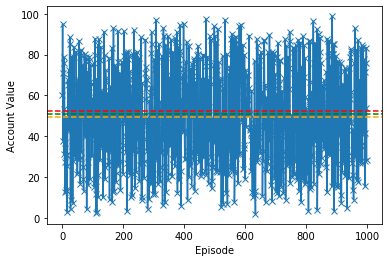

In [6]:
env.dt = 0.05
vals, reler = value_aav(env)

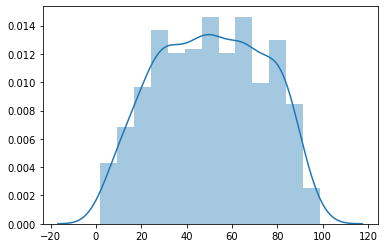

In [7]:
import seaborn as sns
sns.distplot(vals)

[INFO] [2020-05-14 12:16:29,762] [AAV] - Instantiated @ AAV


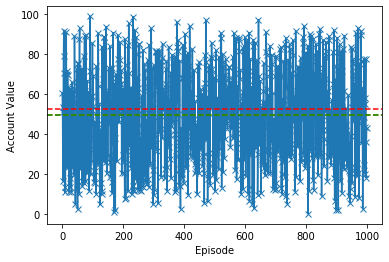

In [8]:
vals, reler = value_aav(denv)

In [12]:
pricer.price(1.11, 100) - 6

68.23515936639073

## Discretize actions

In [14]:
denv = DiscretizedObservationWrapper(env, [40, 25], log=True)
denva = DiscretizedActionWrapper(denv, 4)

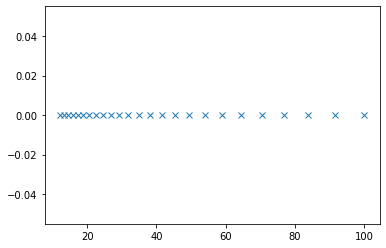

In [18]:
plt.plot(denva.obs_val_bins[1], np.zeros_like(denva.obs_val_bins[1]), 'x')

In [19]:
denva.obs_val_bins[1]

array([100.        ,  91.59436536,  83.89527766,  76.84334714,
        70.38417614,  64.46793945,  59.049     ,  54.0855568 ,
        49.53932251,  45.37522805,  41.56115217,  38.06767357,
        34.86784401,  31.93698044,  29.25247455,  26.79361841,
        24.54144474,  22.47858056,  20.58911321,  18.85846758,
        17.27329369,  15.82136374,  14.49147771,  13.27337704,
        12.15766546])

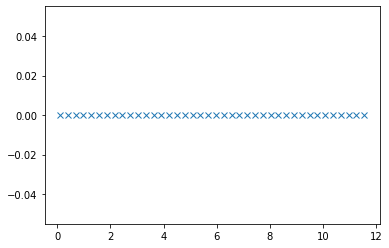

In [20]:
plt.plot(denva.obs_val_bins[0], np.zeros_like(denva.obs_val_bins[0]), 'x')

In [21]:
denva.obs_val_bins[0]

array([ 0.09997559,  0.39348583,  0.68699607,  0.98050631,  1.27401655,
        1.56752679,  1.86103703,  2.15454728,  2.44805752,  2.74156776,
        3.035078  ,  3.32858824,  3.62209848,  3.91560872,  4.20911897,
        4.50262921,  4.79613945,  5.08964969,  5.38315993,  5.67667017,
        5.97018041,  6.26369066,  6.5572009 ,  6.85071114,  7.14422138,
        7.43773162,  7.73124186,  8.0247521 ,  8.31826234,  8.61177259,
        8.90528283,  9.19879307,  9.49230331,  9.78581355, 10.07932379,
       10.37283403, 10.66634428, 10.95985452, 11.25336476, 11.546875  ])

In [22]:
denva.observation_space
denva.action_space

Discrete(4)

In [44]:
ob = denva.reset()
counter = 0
while True:
    counter += 1
    obnext = denva.step(0)
    if ob != obnext[0]:
        print(f'Steps to notice change: {counter}')
        break


Steps to notice change: 11


In [29]:
ob

26

## Q-learning

In [28]:
def initialize_Q(optimal=True):
    Q_table = np.random.rand(denva.observation_space.n, denva.action_space.n)
    if optimal:
        for i in range(Q_table.shape[0]):
            cell = denv._ind_to_cont(i)
            for j in range(Q_table.shape[1]):
                Q_table[i, j] = aav.u(cell[0] + denva.action_val_bins[0][j] , cell[1])
    return Q_table

In [31]:
Q_table = initialize_Q(True)
Q_table

array([[-52.15889089, -57.71619119, -62.57069088, -66.81398431],
       [-47.77460509, -52.86477903, -57.31122722, -61.1978449 ],
       [-43.75884633, -48.42115885, -52.49385485, -56.05377765],
       ...,
       [-13.41277872, -13.49956073, -13.57675196, -13.64552117],
       [-12.28534955, -12.36483697, -12.4355398 , -12.49852852],
       [-11.25268795, -11.32549395, -11.39025376, -11.44794787]])

In [35]:
n_epochs = 100000
epsilon = 0.4  # 10% chances to apply a random action
gamma = 0.8
alpha = 0.8
Q_table = initialize_Q()
def act(ob):
    # Pick the action with highest q value.
    action_scores = Q_table[ob, :]
    action = np.random.choice(np.where(action_scores == np.max(action_scores))[0])
    if np.random.random() < epsilon:
        action = np.random.choice(np.arange(Q_table.shape[1]))
    return action

In [36]:
def update_Q(s, r, a, s_next, done):
    max_q_next = np.max(Q_table[s_next, :])
    # Do not include the next state's value if currently at the terminal state.
    Q_table[s, a] += alpha * (r + gamma * max_q_next * (1.0 - done) - Q_table[s, a])

In [37]:
ob = denva.reset()
rewards = []
reward = 0.0
mean_rewards = []
for epoch in range(n_epochs):
    ob = denva.reset()
    done = False
    while not done:
        a = act(ob)
        ob_next, r, done, _ = denva.step(a)
        update_Q(ob, r, a, ob_next, done)
        reward += r
        if done:
            rewards.append(reward)
            reward = 0.0
        else:
            ob = ob_next
    if epoch % 50== 0 and epoch != 0:
        mean_rew = np.mean(rewards)
        mean_rewards.append(mean_rew)
        rewards = []

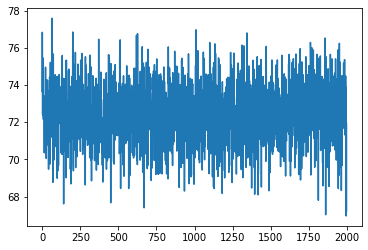

In [38]:
plt.plot(mean_rewards)

In [39]:
def plot_statespace(Q):
    Q.shape[0]
    x = np.zeros(Q.shape[0])
    y = np.zeros(Q.shape[0])
    a = np.zeros(Q.shape[0])
    for i, line in enumerate(Q):
        optimal_ac = np.argmax(line)
        x[i],y[i] = denv._ind_to_cont(i)
        a[i] = denva.action(optimal_ac)
    return x, y, a

In [40]:
y, x, actions = plot_statespace(Q_table)

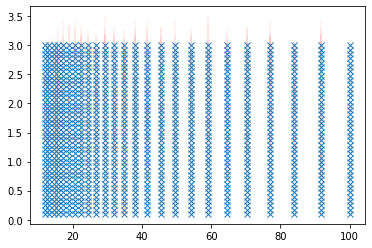

In [41]:
for i, point in enumerate(x):
    plt.plot(x[i], y[i], marker='x', color='C0')
    plt.plot((x[i], x[i]), (y[i], y[i] + actions[i]), color='r', linewidth='0.1')

Eligibility trace

In [62]:
lambd = 0.9 # eligibility decay rate
n_epochs = 50000
epsilon = 0.3  # 10% chances to apply a random action
gamma = 0.8
alpha = 0.5
Q_table = np.random.rand(denva.observation_space.n, denva.action_space.n)
eligibility_table = np.zeros_like(Q_table)

In [63]:
def update_Q_eli(s, r, a, s_next, done):
    global Q_table, eligibility_table
    max_q_next = np.max(Q_table[s_next, :])
    eligibility_table *= lambd
    eligibility_table[s, a] += 1
    Q_table += alpha * (r + gamma * max_q_next - Q_table[s, a]) * eligibility_table 

In [64]:
ob = denva.reset()
rewards = []
reward = 0.0
mean_rewards = []
for epoch in range(n_epochs):
    ob = denva.reset()
    done = False
    while not done:
        a = act(ob)
        ob_next, r, done, _ = denva.step(a)
        update_Q_eli(ob, r, a, ob_next, done)
        reward += r
        if done:
            rewards.append(reward)
            reward = 0.0
        else:
            ob = ob_next
    if epoch % 100 == 0 and epoch != 0:
        mean_rew = np.mean(rewards)
        mean_rewards.append(mean_rew)
        rewards = []

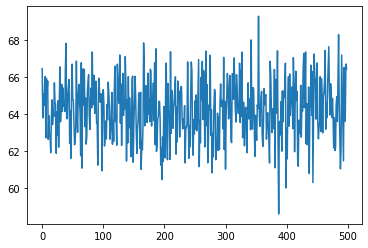

In [66]:
plt.plot(mean_rewards)

In [4]:
def plot_statespace(Q):
    Q.shape[0]
    x = np.zeros(Q.shape[0])
    y = np.zeros(Q.shape[0])
    a = np.zeros(Q.shape[0])
    for i, line in enumerate(Q):
        optimal_ac = np.argmax(line)
        x[i],y[i] = denv._ind_to_cont(i)
        a[i] = denva.action(optimal_ac)
    return x, y, a

## Test Lily's wrapper

In [53]:
from policy.qlearning import QlearningPolicy, TrainConfig
from gym import spaces

p = Parameters()
p.c = 50
aav= AAV(p)

n_actions = 2
MAX_ACTION = 0.3
env = CollectionsEnv()
env.params.c = 50

env.action_space = spaces.Box(low=np.array([0]), high=np.array([MAX_ACTION]), dtype=np.float16)
denv = DiscretizedObservationWrapper(env, n_bins=[10, 10], log=True)
denva = DiscretizedActionWrapper(denv, n_actions)
print(f'N states: {denva.observation_space.n}')
exact_v = -aav.u(env.lambda0, env.w0)
print(exact_v)
config = TrainConfig()
config.n_episodes = 8000

# obs_val_bins = [np.linspace(low_obs[0], high_obs[0], n_bins[0]),
#                             np.logspace(0, 20, base=(1-env.params.r_), num=n_bins[1]) * high_obs[1]]

[INFO] [2020-04-30 14:36:41,309] [AAV] - Instantiated @ AAV
N states: 100
74.95837041365093


[INFO] [2020-04-30 14:38:29,199] [AAV] - Instantiated @ AAV
[FINAL] Num. episodes: 100, Max reward: 81.30553050215322, Average reward: -134.82291211497176
[FINAL] Num. episodes: 200, Max reward: 82.86397068077484, Average reward: -111.80346394203261
[FINAL] Num. episodes: 300, Max reward: 82.86397068077484, Average reward: -115.72919731628023
[FINAL] Num. episodes: 400, Max reward: 82.86397068077484, Average reward: -119.95463144091958
[FINAL] Num. episodes: 500, Max reward: 82.86397068077484, Average reward: -116.10480834743905
[FINAL] Num. episodes: 600, Max reward: 82.86397068077484, Average reward: -117.04835679467448
[FINAL] Num. episodes: 700, Max reward: 82.86397068077484, Average reward: -114.59662171640903
[FINAL] Num. episodes: 800, Max reward: 82.86397068077484, Average reward: -114.07273455988798
[FINAL] Num. episodes: 900, Max reward: 83.47071954721477, Average reward: -114.93835741590689
[FINAL] Num. episodes: 1000, Max reward: 83.47071954721477, Average reward: -115.5470

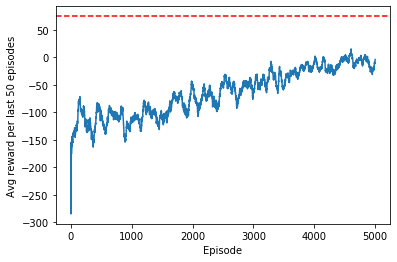

In [56]:
config.warmup_episodes = 4500
config.n_episodes = 5000
config.epsilon = 0.3
config.epsilon_final = 0
config.alpha_decay = 0.9998
config.alpha = 0.89

qln = QlearningPolicy(denv, denva, 'qlearn')
qln.build(optimal=True)

rewn = qln.train(config)
plt.plot(rewn)
plt.axhline(exact_v, linestyle='--', color='red')
plt.xlabel('Episode')
plt.ylabel('Avg reward per last 50 episodes')
plt.show()


In [55]:
qln.Q_table

array([[ 5.21588909e+01,  6.16527975e+01],
       [ 4.12710041e+01,  4.87831091e+01],
       [ 3.26559049e+01,  3.85998985e+01],
       [ 2.58391612e+01,  3.05423782e+01],
       [ 2.04453758e+01,  2.41668217e+01],
       [ 1.61775141e+01,  1.91221282e+01],
       [ 1.28005454e+01,  1.51304872e+01],
       [ 1.01285007e+01,  1.19720798e+01],
       [ 8.01423087e+00,  9.47297277e+00],
       [ 6.34130346e+00,  7.49554087e+00],
       [ 6.78527641e+01,  7.39769013e+01],
       [ 5.36888661e+01,  5.85346227e+01],
       [ 4.24816053e+01,  4.63158364e+01],
       [ 3.36137996e+01,  3.66476557e+01],
       [ 2.65971005e+01,  2.89976555e+01],
       [ 2.10450994e+01,  2.29445515e+01],
       [ 1.66520486e+01,  1.81550003e+01],
       [ 1.31760234e+01,  1.43652421e+01],
       [ 1.04255997e+01,  1.13665754e+01],
       [ 8.24931206e+00,  8.99386417e+00],
       [ 7.79915667e+01,  8.19736081e+01],
       [ 6.42134395e+01,  6.48620601e+01],
       [ 5.08092309e+01,  5.13224554e+01],
       [ 4.

In [26]:
config = TrainConfig()
ql = QlearningPolicy(denv, denva, 'qlearn')
ql.build(optimal=True)
rew = ql.train(config)
plt.plot(rew)
plt.axhline(exact_v, linestyle='--', color='red')
plt.xlabel('Episode')
plt.ylabel('Avg reward per last 50 episodes')
plt.show()



[INFO] [2020-04-30 14:08:18,489] [AAV] - Instantiated @ AAV
[FINAL] Num. episodes: 100, Max reward: 91.12176175029418, Average reward: -297.56881677566724
[FINAL] Num. episodes: 200, Max reward: 91.12176175029418, Average reward: -291.9570619476268
[FINAL] Num. episodes: 300, Max reward: 91.12176175029418, Average reward: -304.2498845795481
[FINAL] Num. episodes: 400, Max reward: 94.19072200980557, Average reward: -308.33709700598143
[FINAL] Num. episodes: 500, Max reward: 94.19072200980557, Average reward: -298.2158394559157
[FINAL] Num. episodes: 600, Max reward: 96.65630130392397, Average reward: -302.28738395567024
[FINAL] Num. episodes: 700, Max reward: 96.65630130392397, Average reward: -302.6106359907538
[FINAL] Num. episodes: 800, Max reward: 96.65630130392397, Average reward: -304.0675497580931
[FINAL] Num. episodes: 900, Max reward: 96.65630130392397, Average reward: -300.7736054878244
[FINAL] Num. episodes: 1000, Max reward: 96.65630130392397, Average reward: -300.2527189422

KeyboardInterrupt: 

[INFO] [2020-04-23 14:49:35,946] [AAV] - Instantiated @ AAV


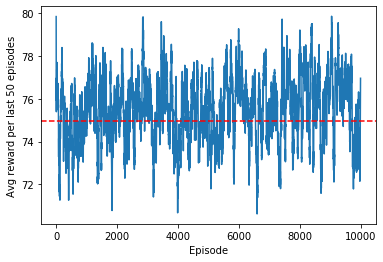

In [87]:
config = TrainConfig()
qleli = QlearningPolicy(denv, denva, 'qlearn')
ql.build(optimal=True)
reweli = ql.train(config, eli=True)
plt.plot(reweli)
plt.axhline(exact_v, linestyle='--', color='red')
plt.xlabel('Episode')
plt.ylabel('Avg reward per last 50 episodes')
plt.show()



In [25]:
def plot_statespace(Q):
    Q.shape[0]
    x = np.zeros(Q.shape[0])
    y = np.zeros(Q.shape[0])
    a = np.zeros(Q.shape[0])
    for i, line in enumerate(Q):
        optimal_ac = np.argmax(line)
        x[i],y[i] = denv._ind_to_cont(i)
        a[i] = denva.action(optimal_ac)
    return x, y, a

Q = ql.Q_table
y, x, actions = plot_statespace(Q)

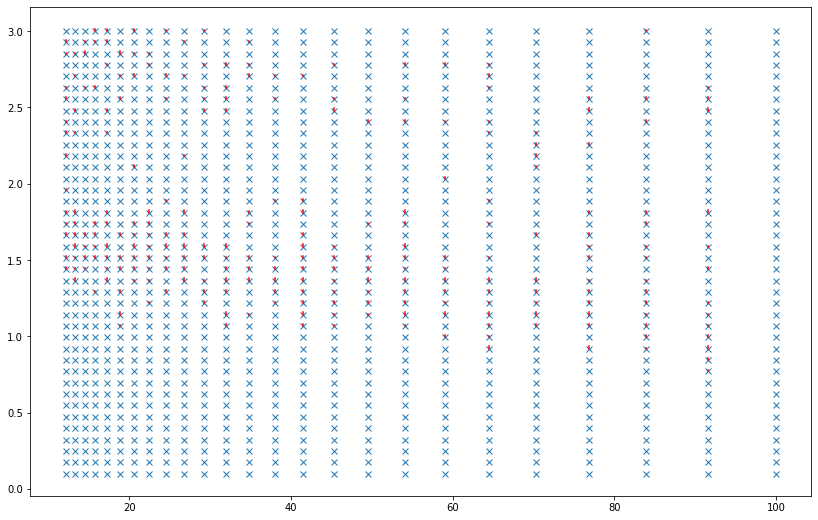

In [26]:
fig, ax = plt.subplots(figsize=(14,9))
for i, point in enumerate(x):
    scalar =  0.05
    ax.plot(x[i], y[i] , marker='x', color='C0')
    ax.plot((x[i], x[i]), (y[i], y[i] + actions[i] * scalar), color='r')

In [46]:
xx, yy = np.meshgrid(denv.obs_val_bins[1], denv.obs_val_bins[0])
Q = ql.Q_table

In [47]:
Q

array([[52.15889089, 52.15889089, 52.15889089],
       [47.77460509, 47.77460509, 47.77460509],
       [43.75884633, 43.75884633, 43.75884633],
       ...,
       [11.53870456,  8.1777107 , 11.67628184],
       [ 7.71852757,  7.62804658,  6.89384805],
       [11.16242381, 11.15619898, 11.07073941]])

In [50]:
a = []
z = np.zeros_like(xx)
for i,xi in enumerate(xx[1]):
    for j,yi in enumerate(yy[:,1]):
        ind = denv.observation(np.array([yi, xi]))
        z[j,i] = np.max(Q[ind,:])

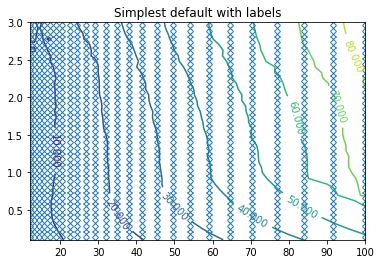

In [88]:
fig, ax = plt.subplots()
CS = ax.contour(xx, yy, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')
for i in xx[1]:
    for j in yy[:,1]:
        ax.plot(i, j , marker='x', color='C0')

In [53]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
import sys, os
import matplotlib.pyplot as plt
sys.path.append('..')
import dcc
p = dcc.Parameters()

[INFO] [2020-04-23 13:26:17,448] [AAV] - Instantiated @ AAV
[INFO] [2020-04-23 13:26:17,467] [OAV] - Launching the value function procedure.
[INFO] [2020-04-23 13:26:17,468] [OAV] - Computing the value function on (0.00, 16.83].
[INFO] [2020-04-23 13:26:17,498] [OAV] - Computing the value function on (16.83, 18.70].
[INFO] [2020-04-23 13:26:21,078] [OAV] - Computing the value function on (18.70, 20.78].
[INFO] [2020-04-23 13:26:23,777] [OAV] - Computing the value function on (20.78, 23.08].
[INFO] [2020-04-23 13:26:25,693] [OAV] - Computing the value function on (23.08, 25.65].
[INFO] [2020-04-23 13:26:28,083] [OAV] - Computing the value function on (25.65, 28.50].
[INFO] [2020-04-23 13:26:29,370] [OAV] - Computing the value function on (28.50, 31.66].
[INFO] [2020-04-23 13:26:31,855] [OAV] - Computing the value function on (31.66, 35.18].
[INFO] [2020-04-23 13:26:34,025] [OAV] - Computing the value function on (35.18, 39.09].
[INFO] [2020-04-23 13:26:37,023] [OAV] - Computing the valu

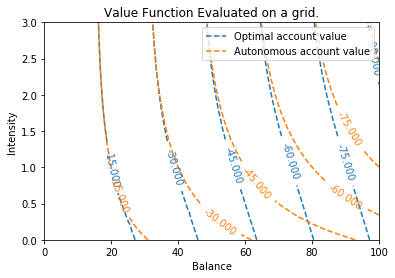

In [60]:
oavfull = dcc.OAV(p, 100, nx=200, ny=20, lmax=3)
oavfull.solve_v()
fig = oavfull.plot_vf(plot_aav_flag=True)

Text(0.5, 1.0, 'Simplest default with labels')

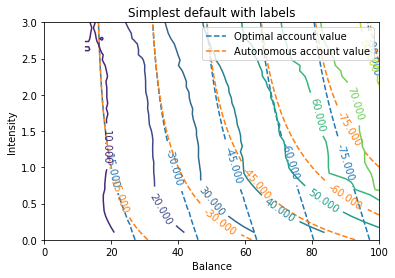

In [89]:
fig, ax = plt.subplots()
cntr1 = ax.contour(oavfull.xx, oavfull.yy, oavfull.zz, colors='C0')
ax.clabel(cntr1, inline=1, fontsize=10)
if True:
    xx_dump, yy_dump, zz_aav = oavfull.aavc.evaluate_aav(oavfull.lambdas_vector, oavfull.w_vector)
    cntr2 = ax.contour(oavfull.xx, oavfull.yy, zz_aav, colors='C1')
    ax.clabel(cntr2, inline=1, fontsize=10)
    h1, _ = cntr1.legend_elements()
    h2, _ = cntr2.legend_elements()
    ax.legend([h1[0], h2[0]], ['Optimal account value', 'Autonomous account value'])
else:
    h1, _ = cntr1.legend_elements()
    ax.legend([h1[0]], ['Optimal account value'])
ax.set_title('Value Function Evaluated on a grid.')
ax.set_ylabel('Intensity')
ax.set_xlabel('Balance')
CS = ax.contour(xx, yy, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

In [49]:
q = np.load('Q_table.npy')

In [56]:
import sys
sys.path.append('..')
from collections_env import CollectionsEnv 
from dcc import Parameters   
lambda0 = 1                    
w0 = 100                       
dt = 0.1                       
s0 = np.array([lambda0, w0])   
p = Parameters()               
env = CollectionsEnv(s0, p, dt)

[INFO] [2020-04-16 13:46:58,878] [CollectionsEnv] - Instantiated @ CollectionsEnv


In [57]:
states_grid = np.array([np.linspace(env.observation_space_low[0], env.observation_space_high[0], 19),
              np.linspace(env.observation_space_low[1], env.observation_space_high[1], 15)])         

In [69]:
np.max(q[1 ,2, :])

0.6175062242810744

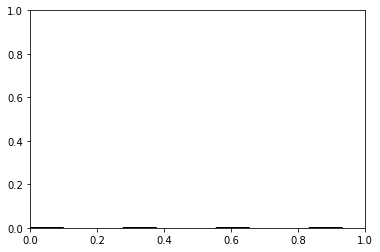

In [90]:
fig, ax = plt.subplots()
for i, l in enumerate(states_grid[0]):
    for j, w in enumerate(states_grid[1]):
        best_action = np.argmax(q[i ,j, :])
        ax.arrow(states_grid[0][i], states_grid[1][j], 0.1, best_action * 0.1, length_includes_head=True)

In [89]:
states_grid[0][i]

5.0

In [62]:
def calc_V(Q_table, epsilon=0):
    # averages over the actions on the Q-table and returns 
    # the corresponding V-table
    n = int(np.sqrt(Q_table.shape[0]))
    V_table = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            state_ind = cell_to_ind((i, j), n)
            V_table[n-1-i, j] = np.max(Q_table[state_ind]) * (1-epsilon) +  epsilon * np.mean(Q_table[state_ind])
    return V_table

In [63]:
calc_V(q, epsilon=0.1)

NameError: name 'cell_to_ind' is not defined